# Goodness-of-fit test with Combine
Assuming background model is rejected events (fail VAE cut) miltiplied by some transfer factor (single number or function of dijet invariant mass)

In [1]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import pandas

from math import log10, floor
from subprocess import Popen
import shlex 

Welcome to JupyROOT 6.12/07


In [2]:
# Set some important variables

# Rescaling the inputs to lumi
qcd_xsec       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec       = 10. #In units of fb (== 0.01 pb) 
sig_gen_events = 972050.0 #(all generated signal)
lumi           = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = 0.8*sig_xsec*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

# Set binning
useDijet = False
# Dijet variable-binwidth binning (depends on dijet resolution)
if useDijet:
    histfile = 'histograms_dijet.root'
    wsfile   = 'datacard_ws_dijet'   #only prefix
    bin_edges = np.array([1126,1181,1246,1313,1383,1455,1530,
                          1607,1687,1770,1856,1945,2037,2132,
                          2231,2332,2438,2546,2659,2775,2895,
                          3019,3147,3279,3416,3558,3704,3854,
                          4010,4171,4337,4509,4686,4869,5058,
                          5253,5500,5663,5877,6099,6328,6564,6808]).astype('float')
    #Use reduced range
    bin_edges = np.array([1246,1313,1383,1455,1530,
                          1607,1687,1770,1856,1945,2037,2132,
                          2231,2332,2438,2546,2659,2775,2895,
                          3019,3147,3279,3416,3558,3704,3854,
                          4010,4171,4337,4509,4686,4869,5058]).astype('float')
#                         5253,5500,5663,5877,6099,6328,6564,6808]).astype('float')
# Constant binwidth
else:
    histfile = 'histograms_100GeV.root'
    wsfile   = 'datacard_ws_100GeV'   #only prefix
    bin_edges = np.array(np.arange(1200., 5000., 100.).tolist()).astype('float') #100 GeV binning
print(bin_edges)
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

# Signal strengths to inject for statistical test
# Define some signal parameters
MX = 3500. #Signal mass in units of GeV
sig_inj_vals = [0,0.1, 1, 2,5,10] #These correspond to xsecs of 0fb(used for GOF w.o signal), 1fb, 10fb, 20fb, 50fb, 100fb

# Where to save data histograms and workspace+datacards


#quantiles
quants = [0.01,0.1,0.3,0.5,0.7,0.9]

#Color style
scol = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
scol.reverse()
bcol = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824'] 
bcol.reverse()

Usign luminosity 63.981237457
Scale QCD with 1.0
Scale signal with 0.000526567460168
[1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900.]


In [3]:
#  Get the total, accepted and rejected events for signal and data
path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_111_210202/'

f_qcd = h5py.File(path+'qcd_sqrtshatTeV_13TeV_PU40_reco.h5', 'r')
f_sig = h5py.File(path+'RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_reco.h5', 'r')

print(f_qcd.keys())
print(list(f_qcd.get("eventFeatureNames")))
print('N QCD events = {}'.format(len(f_qcd.get("eventFeatures"))))

[u'eventFeatureNames', u'eventFeatures']
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss', 'sel_q90', 'sel_q70', 'sel_q50', 'sel_q30', 'sel_q10', 'sel_q01']
N QCD events = 9588767


In [4]:
# Define which columns represent whiich variaibles

mjj_idx = int(np.where(f_qcd['eventFeatureNames'][()] == 'mJJ')[0])
deta_idx = int(np.where(f_sig['eventFeatureNames'][()] == 'DeltaEtaJJ')[0])

# Different quantiles (not yet orthogonal!)
columns   = {}
columns[0.9]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q90')[0]) # 0=rejected 1=accepted
columns[0.7]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
columns[0.5]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q50')[0])
columns[0.3]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q30')[0])
columns[0.1]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q10')[0])
columns[0.01] = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q01')[0])


# Get all features as numpy arrays and apply dEta cut
qcd_tot = np.array(f_qcd.get("eventFeatures"))
sig_tot = np.array(f_sig.get("eventFeatures"))
print('No dEta cut Total = {}'.format(sig_tot.shape[0]))
print('No dEta cut pass q 1% = {}'.format(sig_tot[sig_tot[:,columns[0.01]] == 1].shape[0]))
qcd_tot = qcd_tot[abs(qcd_tot[:,deta_idx]) < 1.40]
sig_tot = sig_tot[abs(sig_tot[:,deta_idx]) < 1.40]
print('With dEta cut Total = {}'.format(sig_tot.shape[0]))
print('With dEta cut pass q 1% = {}'.format(sig_tot[sig_tot[:,columns[0.01]] == 1].shape[0]))

No dEta cut Total = 605887
No dEta cut pass q 1% = 31734
With dEta cut Total = 531825
With dEta cut pass q 1% = 31413


In [5]:
# Define the different dijet invariant mass datasets (total, orthogonal quantiles)
datas_qcd_acc = {}
datas_sig_acc = {}

sig_all      = sig_tot[:,mjj_idx]
qcd_all      = qcd_tot[:,mjj_idx]

#Define the main templates as the 'unused quantile' at 90-100% background efficiency
qcd_template = qcd_tot[qcd_tot[:,columns[0.9]] == 0]
qcd_template = qcd_template[:,mjj_idx]
sig_template = sig_tot[sig_tot[:,columns[0.9]] == 0]
sig_template = sig_template[:,mjj_idx]

# Make sure all quantiles are orthogonal (removing events passing q-1 from q distribution)
qcd = np.copy(qcd_tot)
sig = np.copy(sig_tot)

for key in sorted(columns.keys()):
    
    # Start with q=0.01 and take all events that pass cut on VAE
    datas_qcd_acc[key] = qcd[qcd[:,columns[key]] == 1]
    datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]
    
    datas_sig_acc[key] = sig[sig[:,columns[key]] == 1]
    datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]
    
    #Remove those events from dataset and continue to next quantile
    qcd = qcd[qcd[:,columns[key]] == 0]
    sig = sig[sig[:,columns[key]] == 0]


/afs/cern.ch/user/t/thaarres/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/afs/cern.ch/user/t/thaarres/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'TeX Gyre Heros'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


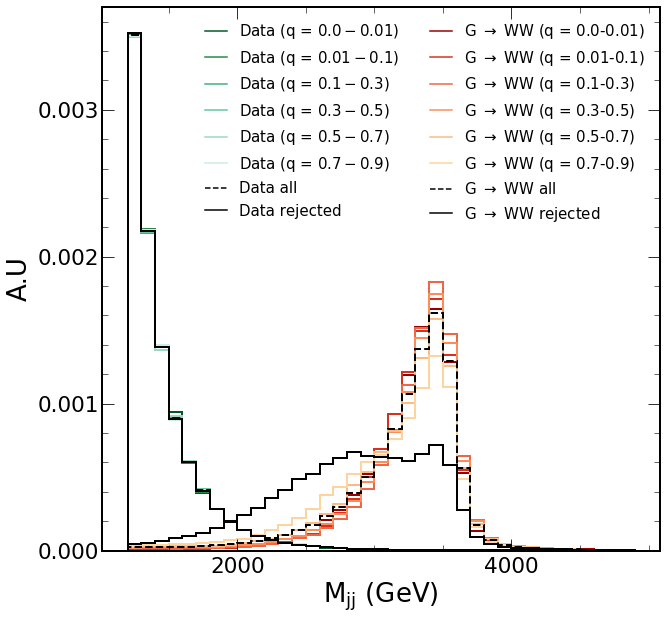

In [6]:
#Some quick control plots to check shapes
import cmsstyle #mplhep for Python2 cheatsheet
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_qcd_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_qcd_acc[key],bins=bin_edges,label=r'Data (q = ${}-{}$)'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=bcol[i],fill=True,density=True)
plt.hist(qcd_all,bins=bin_edges,label=r'Data all',histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True,density=True)
plt.hist(qcd_template,bins=bin_edges,label=r'Data rejected',histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=True)
       
for i,key in enumerate(sorted(datas_sig_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_sig_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_sig_acc[key],bins=bin_edges,label=r'G $\rightarrow$ WW (q = {}-{})'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=scol[i],fill=True,density=True)
    
plt.hist(sig_all,bins=bin_edges,label=r'G $\rightarrow$ WW all',histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True,density=True)
plt.hist(sig_template,bins=bin_edges,label=r'G $\rightarrow$ WW rejected',histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=True)
plt.hist(qcd_all,bins=bin_edges,histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True,density=True)
plt.hist(qcd_template,bins=bin_edges,histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=True)
    
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor(),linestyle=h.get_linestyle()) for h in handles]
plt.ylabel('A.U')
plt.xlabel(u'$M_{jj}$ (GeV)')
plt.locator_params(nbins=4)
plt.legend(handles=new_handles, labels=labels,loc='best',frameon=False, ncol=2,fontsize='xx-small')
plt.savefig('signal_shapes_nolog.pdf')

In [7]:
# Sanity checks

#Check that sum of orthogonal quantiles yield total
print('N total data events = {}'.format(qcd_tot.shape[0]))
sum_quantiles = 0
for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    sum_quantiles += datas_qcd_acc[key].shape[0]
print('Sum of all events up to 90th quantile = {}'.format(sum_quantiles))
print('Sum of all events between 90th-100th quantile = {}'.format(qcd_template.shape[0]))
print('N_total - N_1to90 - N_90to100 = {}'.format(qcd_tot.shape[0]-sum_quantiles-qcd_template.shape[0]))

N total data events = 9588761
Sum of all events up to 90th quantile = 8628589
Sum of all events between 90th-100th quantile = 960172
N_total - N_1to90 - N_90to100 = 0


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure al

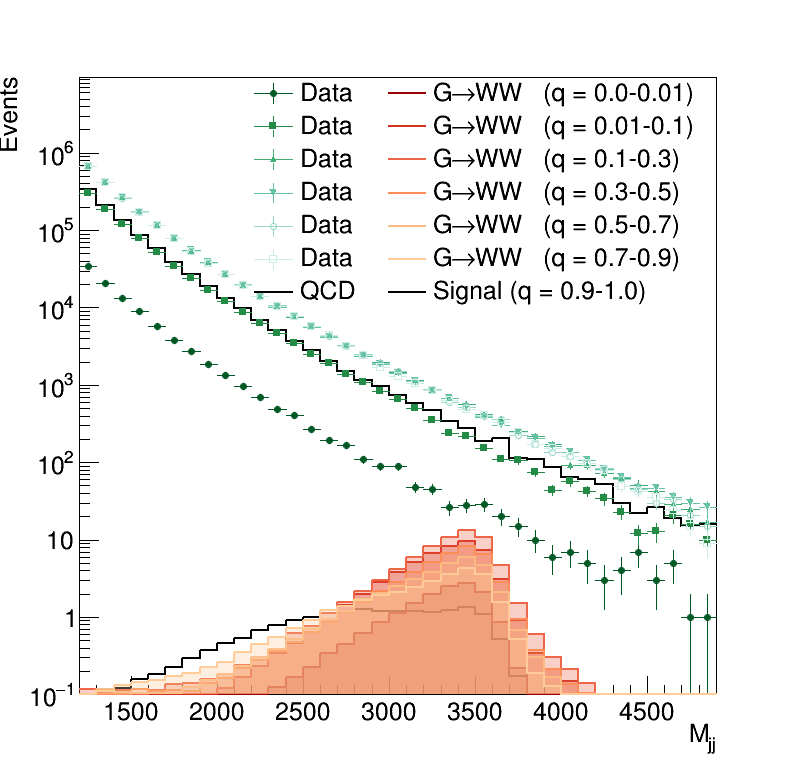

In [8]:
# Fill histograms using dijet binning and proper lumi scaling.
#These are the baseline histograms for statistical analysis.
axis_title = ['M_{jj}','Events']

#Fill and scale to lumi
background_hist_template = rt.TH1D('background_hist_template','background_hist_template',n_bins,bin_edges.astype('float'))
rtnp.fill_hist(background_hist_template, qcd_template, weights=None)
background_hist_template.Scale(scale_qcd)
background_hist_template.SetStats(0)
background_hist_template.Sumw2()

signal_hist_template     = rt.TH1D('signal_rej'    ,'signal_rej'    ,n_bins,bin_edges.astype('float'))
rtnp.fill_hist(signal_hist_template    , sig_template, weights=None)
signal_hist_template.Scale(scale_sig)
signal_hist_template.SetStats(0)
signal_hist_template.Sumw2()

background_hist_template.SetXTitle(axis_title[0])
background_hist_template.SetYTitle(axis_title[1])
background_hist_template.binning = bin_edges
background_hist_template.SetLineColor(rt.kBlack)
background_hist_template.SetLineColor(rt.kBlack)
background_hist_template.SetLineStyle(rt.kSolid)
background_hist_template.SetLineWidth(2)

leg = rt.TLegend(0.31, 0.6, 0.85, 0.9)
leg.SetNColumns(2)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

histos_data = {}
histos_signal = {}
scol = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
scol.reverse()
bcol = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824'] 
bcol.reverse()
colors = ['#d55e00','#cc79a7','#0072b2','#f0e442','#009e73','#b3de69','#fccde5','#d9d9d9']
i = 0
for keyD,keyS in zip( sorted(datas_qcd_acc.keys()), sorted(datas_sig_acc.keys()) ):
    histos_data[keyD]  = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
    histos_signal[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
    rtnp.fill_hist(histos_data[keyD]   , datas_qcd_acc[keyD], weights=None)
    rtnp.fill_hist(histos_signal[keyS] , datas_sig_acc[keyS], weights=None)
    
    histos_data[keyD].Scale(scale_qcd)
    histos_signal[keyS].Scale(scale_sig)
    
    histos_data[keyD]  .SetStats(0)
    histos_signal[keyS].SetStats(0)
    
    histos_data[keyD]  .Sumw2()
    histos_signal[keyS].Sumw2()

    histos_data[keyD].SetXTitle(axis_title[0])
    histos_data[keyD].SetYTitle(axis_title[1])
    histos_data[keyD].binning = bin_edges
    
    histos_signal[keyS].SetXTitle(axis_title[0])
    histos_signal[keyS].SetYTitle(axis_title[1])
    histos_signal[keyS].binning = bin_edges
    
    histos_data[keyD].SetLineColor(rt.TColor.GetColor(bcol[i]))
    histos_data[keyD].SetMarkerColor(rt.TColor.GetColor(bcol[i]))
    
    histos_signal[keyS].SetLineColor(rt.TColor.GetColor(scol[i]))
    histos_signal[keyS].SetLineStyle(rt.kSolid)
    histos_signal[keyS].SetLineWidth(2)
    histos_signal[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[i])), 0.30)

    histos_data[keyD].SetMarkerStyle(20+i)
    histos_data[keyD].SetMarkerSize(0.9)
    i += 1


#Draw
c = rt.TCanvas('c','c',800,800)
background_hist_template.Draw('HIST')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.1)
background_hist_template.SetMaximum(qcd_tot.shape[0])
signal_hist_template.SetLineColor(rt.kBlack)
signal_hist_template.SetLineStyle(rt.kSolid)
signal_hist_template.SetLineWidth(2)
signal_hist_template.Draw('HISTsame')
# signal_hist_template    .Draw('same HIST')

for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
       lower_bound = 0.0 
#     leg.AddEntry(histos_data[key], 'Data (q = {}-{})'.format(lower_bound,key), 'lep')
    leg.AddEntry(histos_data[key], 'Data    ', 'lep')
    leg.AddEntry(histos_signal[key], 'G#rightarrowWW   (q = {}-{})'.format(lower_bound,key), 'l')
    histos_data[key].Draw('pez same')
#     histos_signal[key].Scale(10000.)
    histos_signal[key].Draw('HIST same')   
leg.AddEntry(background_hist_template , 'QCD', 'l')   
leg.AddEntry(signal_hist_template , 'Signal (q = 0.9-1.0)', 'l') 
c.SetLogy()
c.SetTitle('')

leg.Draw("same")
c.Draw()

0


Info in <TCanvas::Print>: pdf file mjj_all.pdf has been created


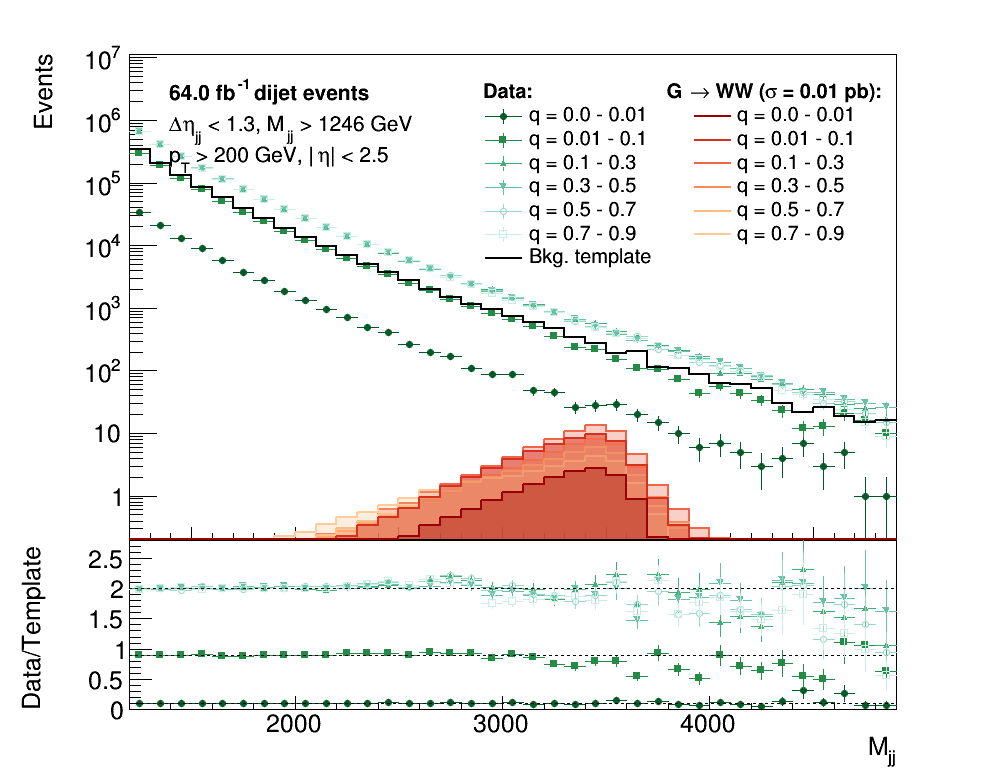

In [9]:
# Draw "nice" ratio plot for paper, check efficiency quantile/template and smoothness

c_out = rt.TCanvas("ratio", "", 1000, 800)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
# pad1.SetGridx()
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.48, 0.5, 0.89, 0.85)
leg.SetNColumns(2)
leg.SetTextSize(0.05)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

background_hist_template.Draw('HIST')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.2)
background_hist_template.SetMaximum(qcd_tot.shape[0]*1.2)
background_hist_template.GetYaxis().SetLabelSize(0.05)
background_hist_template.GetYaxis().SetTitleSize(0.05)
# signal_hist_template    .Draw('same HIST')
leg.SetTextSize (0.03)
leg.SetTextFont( 62 )
leg.SetHeader('Data:                        G #rightarrow WW (#sigma = 0.01 pb):')
leg.SetTextSize (0.03)
leg.SetTextFont( 42 )
for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
       lower_bound = 0.0 
    histos_data[key].Draw('pez same')
    histos_signal[key].Draw('HIST same')
    leg.AddEntry(histos_data[key]  , 'q = {} - {}'.format(lower_bound,key), 'lep')
    leg.AddEntry(histos_signal[key], 'q = {} - {}'.format(lower_bound,key), 'l')
background_hist_template.Draw('same HIST')
histos_signal[0.1].Draw('HIST same')
histos_signal[0.01].Draw('HIST same')
leg.SetTextSize(0.04)  
leg.AddEntry(background_hist_template , 'Bkg. template', 'l') 
leg.Draw('same')

pad1.SetLogy()
pad1.SetTitle('')

c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio = {}
tline = {}
for i,key in enumerate(sorted(histos_data.keys())):
    pad2.cd()
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
    data_hist_ratio[key] = histos_data[key].Clone('data_hist_ratio_{}'.format(i))
    
    data_hist_ratio[key].Divide(background_hist_template)
    data_hist_ratio[key].binning = bin_edges
    # data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())
    if i == 0:
        print(i)
        data_hist_ratio[key].SetTitle('')
        data_hist_ratio[key].Draw('pez')
        data_hist_ratio[key].SetMaximum(2.8)
        data_hist_ratio[key].SetMinimum(0.0)
        data_hist_ratio[key].SetYTitle('Data/Template')
        data_hist_ratio[key].GetYaxis().SetTitleOffset(0.5)
        data_hist_ratio[key].GetYaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetYaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetYaxis().SetNdivisions(506)
        data_hist_ratio[key].GetXaxis().SetNdivisions(506)
        data_hist_ratio[key].GetXaxis().SetTitleOffset(0.95)
        data_hist_ratio[key].GetXaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetXaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetXaxis().SetTickSize(0.07)
    else:
        data_hist_ratio[key].Draw('pez same')
    
    
    tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')

# sig_hist_ratio = signal_hist_acc.Clone('signal_hist_ratio')
# sig_hist_ratio.SetTitle('')
# sig_hist_ratio.Sumw2()
# sig_hist_ratio.Divide(signal_hist_rej)
# sig_hist_ratio.binning = bin_edges
# data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())

# sig_hist_ratio.Draw('pez same')
c_out.cd()
latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.03)
latex.SetTextFont( 62 )
latex.DrawLatex (0.17 ,0.87 , "%.1f fb^{-1} dijet events"%lumi)
latex.SetTextSize (0.03)
latex.SetTextFont( 42 )
latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1246 GeV")
latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
c_out.SaveAs('mjj_all.pdf')

In [10]:
# define data for 90-100% quantile (used for control region datacards)
histos_data  [1.0] = background_hist_template
histos_signal[1.0] = signal_hist_template

\begin{tabular}{lrrrrrrr}
\toprule
          q & $\sigma$ [fb] & $N_{bkg}$ & $N_{sig}$ & $S/\sqrt{B}$ & $N_{bkg}$ ($M_{X} \pm 10\%$) & $N_{sig}$ ($M_{X} \pm 10\%$) & $S/\sqrt{B}$ ($M_{X} \pm 10\%$) \\
\midrule
 0.0 - 0.01 &             1 &     96660 &         1 &        0.003 &                          528 &                            1 &                            0.04 \\
 0.0 - 0.01 &            10 &     96660 &        16 &        0.050 &                          528 &                           14 &                            0.60 \\
 0.0 - 0.01 &            20 &     96660 &        33 &        0.100 &                          528 &                           29 &                            1.00 \\
 0.0 - 0.01 &            50 &     96660 &        82 &        0.300 &                          528 &                           73 &                            3.00 \\
 0.0 - 0.01 &           100 &     96660 &       165 &        0.500 &                          528 &                          1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Info in <TCanvas::Print>: pdf file sigInj_all.pdf has been created


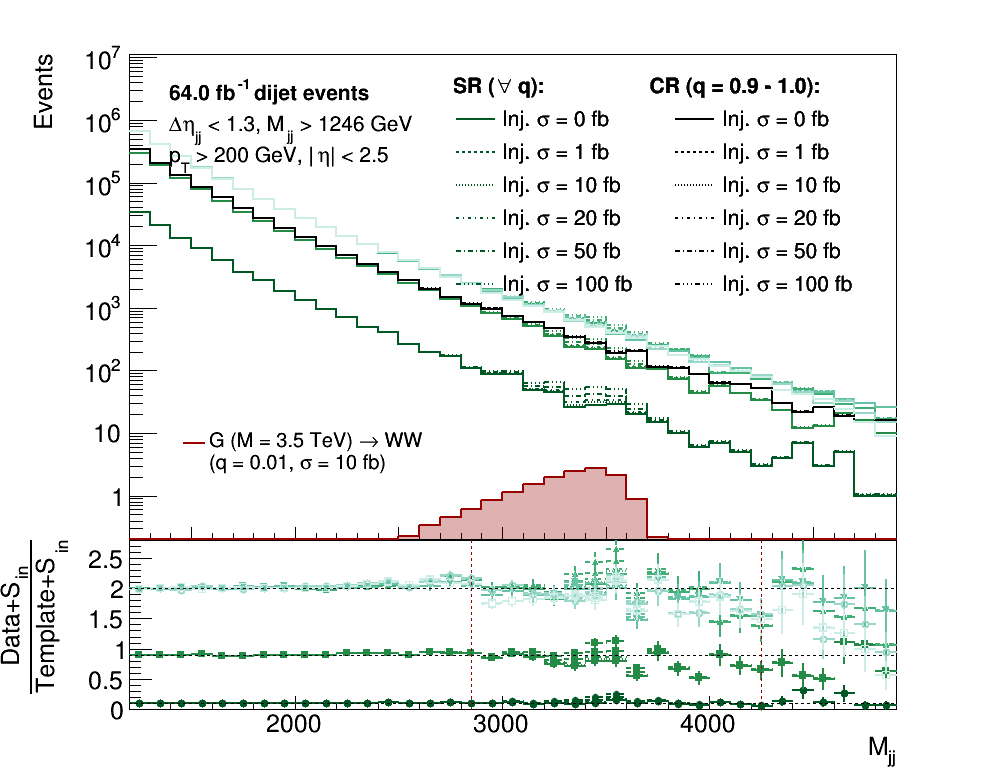

In [11]:
# Make data with injected signal!
# Do some validation checks and plot data distribution with injected signal.
# Also make table with S/sqrt(B) over full dijet range and in mJJ window.

data = {'q':[],'q_string':[],'sig_inj':[],'mjjmin':[],  'mjjmax':[], 'NQCD':[], 'NSIG':[],'SB':[],'NQCD_SLICE':[], 'NSIG_SLICE':[],'SB_SLICE':[]}
        
# These dictionaries will contain the 90-100% quantile with injected signal (data_hist_rej_inj_all)
# and the orthogonal quantiles with injected signal (data_hist_acc_inj_all). They will be saved to 'histfile'
# The format is data_hist_rej_inj_all[quantile][sig_injected]

data_hist_rej_inj_all = {}
data_hist_acc_inj_all = {}

#Define signal Mjj window as 20% of each side of MX. Only used for drawing purposes and S/sqrt(B) values
axis = background_hist_template.GetXaxis()
bmin = axis.FindBin(MX*0.8)
bmax  = axis.FindBin(MX*1.2)
mjjmin = axis.GetBinCenter(bmin)
mjjmax = axis.GetBinCenter(bmax)

# Helper function to round numbers for TeX table
def round_sig(x, sig=1):
    if x == 0.:
        return 0
    else:
        return round(x, sig-int(floor(log10(abs(x))))-1)


leg = rt.TLegend(0.48, 0.5, 0.89, 0.85)
#stick to no injecion for now
c_out = rt.TCanvas("ratio", "", 1000, 800)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
pad1.SetLogy()
pad1.SetTitle('')
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.45, 0.61, 0.89, 0.91)
leg.SetNColumns(2)
leg.SetTextSize(0.05)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize (0.03)
leg.SetTextFont( 62 )
leg.SetHeader('SR (#forall q):                  CR (q = 0.9 - 1.0):')
leg.SetTextSize (0.03)
leg.SetTextFont( 42 )
background_hist_template.Draw('HIST')
histos_signal[0.01].Draw('HISTsame')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.2)
background_hist_template.SetMaximum(qcd_tot.shape[0]*1.2)
background_hist_template.GetYaxis().SetLabelSize(0.05)
background_hist_template.GetYaxis().SetTitleSize(0.05)


for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
#     if key == 1.0: #To skip reject quantile
#        continue
    prefix = 'q'+str(int(key*100))
#     print(prefix) 
#     print('Quantile integral = {}'.format(histos_data[key].Integral()))
#     print('Template integral = {} (10%efficiency)'.format(background_hist_template.Integral()))
#     print('Efficiency= {}'.format(histos_data[key].Integral()/background_hist_template.Integral()))
    
    data_hist_rej_inj = {}
    data_hist_acc_inj = {}
    for k,sig_inj in enumerate(sig_inj_vals):
        data_hist_rej_inj[sig_inj] = background_hist_template.Clone('background_hist_template_inj{}_{}'.format(sig_inj,prefix))
        data_hist_acc_inj[sig_inj] = histos_data[key].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,prefix))
        data_hist_rej_inj[sig_inj].Add(signal_hist_template,sig_inj)
        data_hist_acc_inj[sig_inj].Add(histos_signal[key],sig_inj)
        
        # Compute some useful S/B quantities and print as latex table
        if sig_inj != 0:
            data['q'].append(key)
            keystring = '{} - {}'.format(lower_bound,key)
            data['q_string'].append(keystring)
            data['sig_inj'].append(int(sig_inj*10.))
            data['mjjmin'].append(mjjmin)
            data['mjjmax'].append(mjjmax)
            NQCD       = int(histos_data[key].Integral())
            NSIG       = int(data_hist_acc_inj[sig_inj].Integral())-int(histos_data[key].Integral())
            SB         = round_sig(NSIG/np.sqrt(NQCD))
            NQCD_SLICE = int(histos_data[key].Integral(bmin,bmax))
            NSIG_SLICE = int(data_hist_acc_inj[sig_inj].Integral(bmin,bmax))-int(histos_data[key].Integral(bmin,bmax))
            SB_SLICE   = round_sig(NSIG_SLICE/np.sqrt(NQCD_SLICE))
            data['NQCD'].append(NQCD)
            data['NSIG'].append(NSIG)
            data['SB'].append(SB)
            data['NQCD_SLICE'].append(NQCD_SLICE)
            data['NSIG_SLICE'].append(NSIG_SLICE)
            data['SB_SLICE'].append(SB_SLICE)
        if key != 1.0:
            data_hist_acc_inj[sig_inj].SetLineColor(rt.TColor.GetColor(bcol[i]))
            data_hist_acc_inj[sig_inj].SetLineStyle(k+1)
            data_hist_rej_inj[sig_inj].SetLineStyle(k+1)
            data_hist_acc_inj[sig_inj].SetLineWidth(2)
            data_hist_rej_inj[sig_inj].SetLineWidth(2)
            data_hist_rej_inj[sig_inj].Draw('sameHIST')
            data_hist_acc_inj[sig_inj].Draw('sameHIST')
        if key == 0.01:
            leg.AddEntry(data_hist_acc_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
            leg.AddEntry(data_hist_rej_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
            
        
    data_hist_rej_inj_all[key] = data_hist_rej_inj
    data_hist_acc_inj_all[key] = data_hist_acc_inj
    
dataP = pandas.DataFrame(data)
dataP.to_pickle('Yields.pkl')
print(dataP.to_latex(columns=['q_string','sig_inj','NQCD','NSIG','SB','NQCD_SLICE','NSIG_SLICE','SB_SLICE'],header=['q','$\sigma$ [fb]','$N_{bkg}$','$N_{sig}$','$S/\sqrt{B}$','$N_{bkg}$ ($M_{X} \pm 10\%$)','$N_{sig}$ ($M_{X} \pm 10\%$)','$S/\sqrt{B}$ ($M_{X} \pm 10\%$)'],index=False,escape=False)) 
leg2 = rt.TLegend(0.18, 0.12, 0.3, 0.2)
leg2.SetBorderSize(0)
leg2.SetFillStyle(0)
leg2.SetTextSize (0.04)
leg2.SetTextFont( 42 )
leg2.AddEntry(histos_signal[0.01],'G (M = 3.5 TeV) #rightarrow WW','l')
leg2.AddEntry(None,'(q = 0.01, #sigma = 10 fb)','')
leg2.Draw('same')
c_out.Update()


# Add ratio SRinj/CRinj
c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio_all = {}
tline = {}
for i,key in enumerate(sorted(histos_data.keys())):
    if key == 1.0:
        continue
    data_hist_ratio = {}
    pad2.cd()
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
    
    for k,sig_inj in enumerate(sig_inj_vals):
        
        data_hist_ratio[sig_inj] = data_hist_acc_inj_all[key][sig_inj].Clone('data_hist_ratio_{}{}'.format(i,k))
        data_hist_ratio[sig_inj].Divide(data_hist_rej_inj_all[key][sig_inj])
        data_hist_ratio[sig_inj].binning = bin_edges

        if k == 0 and i == 0:
            data_hist_ratio[sig_inj].SetTitle('')
            data_hist_ratio[sig_inj].Draw('pez')
            data_hist_ratio[sig_inj].SetMaximum(2.8)
            data_hist_ratio[sig_inj].SetMinimum(0.0)
            data_hist_ratio[sig_inj].SetYTitle('#frac{Data+S_{in}}{Template+S_{in}}')
            data_hist_ratio[sig_inj].GetYaxis().SetTitleOffset(0.5)
            data_hist_ratio[sig_inj].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[sig_inj].Draw('pez same')
    
    data_hist_ratio_all[key] = data_hist_ratio
    
    tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')

vlineDown = rt.TLine(mjjmin, 0.0, mjjmin, 2.8)
vlineDown.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineDown.SetLineStyle(rt.kDashed)
vlineDown.Draw('same')
vlineUp = rt.TLine(mjjmax, 0.0, mjjmax, 2.8)
vlineUp.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineUp.SetLineStyle(rt.kDashed)
vlineUp.Draw('same')
c_out.cd()


latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.03)
latex.SetTextFont( 62 )
latex.DrawLatex (0.17 ,0.87 , "%.1f fb^{-1} dijet events"%lumi)
latex.SetTextSize (0.03)
latex.SetTextFont( 42 )
latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1246 GeV")
latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
leg.Draw('same')
c_out.SaveAs('sigInj_all.pdf')


leg.Draw('same')
c_out.Draw()       

In [12]:
# Make sure the data is correctly created and store all histograms to file (will be imported to workspace below)

outfile = rt.TFile(histfile, 'RECREATE' )

signal_hist_template.Write('signal_template')
background_hist_template.Write('background_template')
for i,qkey in enumerate(sorted(data_hist_acc_inj_all.keys())):
    quantile = int(qkey*100)
    histos_signal[qkey].Write('signal_q{}percent'.format(quantile))
    histos_data[qkey].Write('background_q{}percent'.format(quantile))
    for i,skey in enumerate(sorted(data_hist_acc_inj_all[key])):
        injected = int(skey*10.)
        prefix = 'inj{}fb_q{}percent'.format(injected,quantile)
        print('Quantile={} signalInj={}'.format(qkey,injected))
        print('{}: {} events'.format('data_acc_{}'.format(prefix),data_hist_acc_inj_all[qkey][skey].Integral()))
        data_hist_acc_inj_all[qkey][skey].Write('data_acc_{}'.format(prefix))
        data_hist_rej_inj_all[qkey][skey].Write('data_rej_{}'.format(prefix))


outfile.Close()        

Quantile=0.01 signalInj=0
data_acc_inj0fb_q1percent: 96660.0 events
Quantile=0.01 signalInj=1
data_acc_inj1fb_q1percent: 96661.6512102 events
Quantile=0.01 signalInj=10
data_acc_inj10fb_q1percent: 96676.5121024 events
Quantile=0.01 signalInj=20
data_acc_inj20fb_q1percent: 96693.0242048 events
Quantile=0.01 signalInj=50
data_acc_inj50fb_q1percent: 96742.5605121 events
Quantile=0.01 signalInj=100
data_acc_inj100fb_q1percent: 96825.1210242 events
Quantile=0.1 signalInj=0
data_acc_inj0fb_q10percent: 859768.0 events
Quantile=0.1 signalInj=1
data_acc_inj1fb_q10percent: 859773.576929 events
Quantile=0.1 signalInj=10
data_acc_inj10fb_q10percent: 859823.769286 events
Quantile=0.1 signalInj=20
data_acc_inj20fb_q10percent: 859879.538573 events
Quantile=0.1 signalInj=50
data_acc_inj50fb_q10percent: 860046.846431 events
Quantile=0.1 signalInj=100
data_acc_inj100fb_q10percent: 860325.692863 events
Quantile=0.3 signalInj=0
data_acc_inj0fb_q30percent: 1920439.0 events
Quantile=0.3 signalInj=1
data_acc

In [13]:
# #Open histogram file and make workspace

# Which quantiles to look at
quants = [0.01]

for i,qkey in enumerate(quants):
    f = rt.TFile.Open(histfile,"r")
    #Which dataset (signal injected or not).  
    #for skey in sig_inj_valskeys.keys():
    skey = int(0) #Stick to no injected signal for now
    quantile = int(qkey*100)
    prefix = 'inj{}fb_q{}percent'.format(skey,quantile) #different name for all quantiles/injected signal
    
    # Get histograms
    background_hist_rej = f.Get('data_rej_{}'.format(prefix)); background_hist_rej.SetDirectory(0);
    background_hist_acc = f.Get('data_acc_{}'.format(prefix)); background_hist_acc.SetDirectory(0);
    signal_hist_acc     = f.Get('signal_q{}percent'.format(quantile)) ; signal_hist_acc.SetDirectory(0);
    signal_hist_rej     = f.Get('signal_template') ; signal_hist_rej.SetDirectory(0);
    f.Close() 
    print('Acc data {} events'.format(background_hist_acc.Integral()))
    print('Rej data {} events'.format(background_hist_rej.Integral()))
    print('Acc signal {} events'.format(signal_hist_acc.Integral()))
    print('Rej signal {} events'.format(signal_hist_rej.Integral()))
    
    #background_hist_acc.Scale(background_hist_rej.Integral()/background_hist_acc.Integral()) # Test if fit converges if normalizatins are same
    
    #TEST: set up SIMPLE worksapece for debugging (1-to-1 with Javiers code)
    efficiency = background_hist_acc.Integral()/background_hist_rej.Integral() #How much rej histogram needs to be scaled to match acc
    print('Using efficiency = {} '.format(efficiency))
    
    datacard_ws = rt.TFile.Open('{}_{}.root'.format(wsfile,prefix),'recreate')
    w = rt.RooWorkspace('w','w')
    x = rt.RooRealVar('x','x',min_bin,max_bin)
    w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

    acc_bin_functions = rt.RooArgList()
    rej_bin_functions = rt.RooArgList()
    w.factory('eff[%f,%f,%f]'%(efficiency,np.maximum(0.,efficiency*0.2),np.maximum(1.,efficiency*2)))
    w.var('eff').setConstant(False) #I'm letting this float for now

    empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
    for iBinX in range(1,n_bins+1):
        print('Bin {}'.format(iBinX))
        print('Eff = {}'.format(efficiency))
        print('Background model = {}'.format(background_hist_rej.GetBinContent(iBinX)))
        print('Data             = {}'.format(background_hist_acc.GetBinContent(iBinX)))
        print('Prediction       = {}'.format(background_hist_rej.GetBinContent(iBinX)*efficiency))
        mjj = background_hist_rej.GetBinContent(iBinX)
        tsB = mjj*pow(1.0+1/np.sqrt(mjj),iBinX)
        print('Test statistics bkg.= {}'.format(tsB))
        mjj_data = background_hist_acc.GetBinContent(iBinX)
        tsD = mjj_data*pow(1.0+1/np.sqrt(mjj_data),iBinX)
        print('Test statistics data = {}'.format(tsD))
        print('Test statistics esti = {}'.format(tsB*efficiency))
#         print('Test statistics = {}'format(background_hist_rej.GetBinContent(iBinX)*pow(1.0+1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX),iBinX))))
        empty_hist.SetBinContent(iBinX,1)
        w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_rej.GetBinContent(iBinX)))
        w.factory('crBin%i[0,-10,10]'%(iBinX))
        w.var('crBin%i_In'%iBinX).setConstant(True)
        w.var('crBin%i'%iBinX).setConstant(False)
        #Added this as zero bin content protection. Commenting it out for now and making sure only non-zero binis are present
        if background_hist_rej.GetBinContent(iBinX) !=  0.:
            power = 1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX))
        else:
            power = 0.0
        #what is fit is actually (mjj+mjj/sqrt(mjj))^x_bin, meaning x_bin is representative of how many sigma acc is from rej
        w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,power,iBinX,iBinX))
        w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
        rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
        acc_bin_functions.add(w.function('bin%iFunc'%iBinX))

    qcd_rph_rej = rt.RooParametricHist('background_rej','background_acc',w.var('x'),rej_bin_functions,empty_hist)
    qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
    qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
    qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
    getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
    getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
    getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
    getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

    ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_hist_acc)
    ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_rej)
    getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
    getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

    sig_inj = 0
    ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),background_hist_acc)
    ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),background_hist_rej)
    getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
    getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

    datacard_ws.cd()
    w.Write()
    datacard_ws.Close()
    w.var('eff').Print()
    del w

Acc data 96660.0 events
Rej data 960139.0 events
Acc signal 16.5121024159 events
Rej signal 18.8274195383 events
Using efficiency = 0.1006729234 
Bin 1
Eff = 0.1006729234
Background model = 338072.0
Data             = 34070.0
Prediction       = 34034.6965596
Test statistics bkg.= 338653.439593
Test statistics data = 34254.5806057
Test statistics esti = 34093.2317831
Bin 2
Eff = 0.1006729234
Background model = 208905.0
Data             = 20966.0
Prediction       = 21031.0770628
Test statistics bkg.= 209820.12253
Test statistics data = 21256.5928176
Test statistics esti = 21123.2051232
Bin 3
Eff = 0.1006729234
Background model = 133033.0
Data             = 13217.0
Prediction       = 13392.8210186
Test statistics bkg.= 134130.213416
Test statistics data = 13564.9043347
Test statistics esti = 13503.2807008
Bin 4
Eff = 0.1006729234
Background model = 86258.0
Data             = 9106.0
Prediction       = 8683.84502661
Test statistics bkg.= 87438.8021227
Test statistics data = 9493.74348141
Te

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooParametricHist::background_rej
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin1Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1 for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin2Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin2_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVa

In [14]:
# datacard template
# no background normalization uncertainty
for i,qkey in enumerate(quants):
    f = rt.TFile.Open(histfile,"r")
    skey = int(0)
    quantile = int(qkey*100)
    prefix = 'inj{}fb_q{}percent'.format(skey,quantile)
    signal_hist_acc     = f.Get('signal_q{}percent'.format(quantile)); signal_hist_acc.SetDirectory(0);
    signal_hist_rej     = f.Get('signal_template')                   ; signal_hist_rej.SetDirectory(0);
    f.Close()
    wsname = '{}_{}.root'.format(wsfile,prefix)
    datacard_ratio = \
    '''
    imax 1
    jmax 1
    kmax *
    ---------------
    shapes * * {WS} w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
    ---------------
    bin {BIN}
    observation {OBS}
    ------------------------------
    bin             {BIN}      {BIN}
    process         signal     background
    process         0          1
    rate            {SIGRATE}    {BKGRATE}
    --------------------------------
    lumi lnN 1.01 -
    eff   flatParam
    '''

    for i in range(1,n_bins+1):
        datacard_ratio += 'crBin%i   flatParam\n'%i

    # write datacard
    datacard_ratio_acc = datacard_ratio.format(WS=wsname,
                                               BIN='acc',
                                               OBS=-1,
                                               BKGRATE=1,
                                               SIGRATE=signal_hist_acc.Integral())
    print(datacard_ratio_acc)
    with open('{}_ratio_acc_{}.txt'.format(wsfile,prefix),'w') as f:
        f.write(datacard_ratio_acc)


    datacard_ratio_rej = datacard_ratio.format(WS=wsname,
                                               BIN='rej',
                                               OBS=-1,
                                               BKGRATE=1,
                                               SIGRATE=signal_hist_rej.Integral())
    print(datacard_ratio_rej)
    with open('{}_ratio_rej_{}.txt'.format(wsfile,prefix),'w') as f:
        f.write(datacard_ratio_rej)


    imax 1
    jmax 1
    kmax *
    ---------------
    shapes * * datacard_ws_100GeV_inj0fb_q1percent.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
    ---------------
    bin acc
    observation -1
    ------------------------------
    bin             acc      acc
    process         signal     background
    process         0          1
    rate            16.5121024159    1
    --------------------------------
    lumi lnN 1.01 -
    eff   flatParam
    crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   fla

In [15]:
for i,qkey in enumerate(quants):
    skey = int(0)
    quantile = int(qkey*100)
    prefix = 'inj{}fb_q{}percent'.format(skey,quantile)
    get_ipython().system(u'combineCards.py rej={WNAME}_ratio_rej_{P}.txt acc={WNAME}_ratio_acc_{P}.txt > {WNAME}_ratio_{P}.txt'.format(P=prefix, WNAME=wsfile))

In [16]:
# Simple test and fit diagnostics
prefix = 'inj{}fb_q{}percent'.format(0,1)
get_ipython().system('combine -M FitDiagnostics -d {WNAME}_ratio_{P}.txt -n _fit_result --saveShapes --saveWithUncertainties --dataset data_obs -v 2'.format(P=prefix, WNAME=wsfile))
get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d {WNAME}_ratio_{P}.txt -n {WNAME}_Ratio_{P} --dataset data_obs -v 2'.format(P=prefix, WNAME=wsfile))


>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Creating pdfs for individual modes (2): .    .   done.
Importing combined pdf model_s
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-ndKqYv.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Warning! -- You haven't picked default values for the Parameters of Interest (either with --expectSignal or --setParameters) for generating toys. Combine will use the 'B-only' ModelConfig to generate, which may lead to undesired behaviour if not using the default Physics Model
SimNLL created with 0 channels, 0 generic constraints, 1 fast gaussian constraints, 0 fast poisson constraints, 0 fast group constraints, 
SimNLL created with 2 channels, 0 generic constraints, 1 fast gaussian constraints, 0 fast poisson constraints, 0 fast group constraints, 

  RooFitResult: minimized FCN value: -3.2454, estimated distance to minimum: 9.63468e-06
  


  RooFitResult: minimized FCN value: -3.40112, estimated distance to minimum: 2.39696e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
            crBin10_In    9.7420e+03
            crBin11_In    6.8980e+03
            crBin12_In    5.0880e+03
            crBin13_In    3.7160e+03
            crBin14_In    2.8180e+03
            crBin15_In    2.0260e+03
            crBin16_In    1.4940e+03
            crBin17_In    1.1590e+03
            crBin18_In    9.7300e+02
            crBin19_In    7.2900e+02
             crBin1_In    3.3807e+05
            crBin20_In    5.8500e+02
            crBin21_In    4.7200e+02
            crBin22_In    3.3700e+02
            crBin23_In    2.7400e+02
            crBin24_In    1.9000e+02
            crBin25_In    2.0600e+02
            crBin26_In    1.1400e+02
            crBin27_In    1.1100e+02
          


 --- FitDiagnostics ---
Best fit r: 0.318993  -0.318993/+1.20073  (68% CL)
Done in 0.15 min (cpu), 0.15 min (real)
Printing Message Summary From ... combine_logger.out
----------------------------------------------
Messages of type INFO : 13
Messages of type DEBUG : 2
Messages of type ERROR : 0
----------------------------------------------
INFO: (function: getNormalizations) FitDiagnostics.cc: 780 -- Generating toy data for evaluating per-bin uncertainties and covariances with post-fit nuisance parameters with 200 toys
INFO: (function: improveOnce) CascadeMinimizer.cc: 184 -- Minimisation configured with Type=Minuit2, Algo=Migrad, strategy=1, tolerance=0.1
INFO: (function: improveOnce) CascadeMinimizer.cc: 207 -- Minimisation finished with status=0
INFO: (function: improveOnce) CascadeMinimizer.cc: 212 -- Minimization success! status=0
INFO: (function: improveOnce) CascadeMinimizer.cc: 184 -- Minimisation configured with Type=Minuit2, Algo=Migrad, strategy=1, tolerance=0.1
INFO: (fun

In [17]:
# Loop over all quantiles, datasetts and do GF with toys and on real dataset
from subprocess import Popen
import shlex 
for i,qkey in enumerate(quants):
    for sig_inj in sig_inj_vals:
        skey = int(0)
        quantile = int(qkey*100)
        prefix = 'inj{}fb_q{}percent'.format(skey,quantile)
        # get obseverved goodness of fit test statistic (signal strength = 0)
        get_ipython().system('combine -M GoodnessOfFit --algo saturated --expectSignal 0 --fixedSignalStrength 0 -d {WNAME}_ratio_{P}.txt -n {WNAME}_Ratio_{P} --dataset data_obs'.format(P=prefix, WNAME=wsfile))

        processes = []
        # get expected goodness of fit test statistic distribution from frequentist toys
        for i in range(10):
            command = 'combine -M GoodnessOfFit --algo saturated --expectSignal 0 --fixedSignalStrength 0 -d {WNAME}_ratio_{P}.txt -t 200 --toysFreq -n {WNAME}_Ratio_{P}  --dataset data_obs -s {SEED}'.format(P=prefix,SEED=40+i, WNAME=wsfile)
            processes.append(Popen(shlex.split(command)))
            #get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i))
        for p in processes:
            p.wait()
        get_ipython().system('hadd -f higgsCombine{WNAME}_Ratio_{P}.GoodnessOfFit.mH120.123456.root higgsCombine{WNAME}_Ratio_{P}.GoodnessOfFit.mH120.4*.root'.format(P=prefix,WNAME=wsfile))
        break
    break

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 59.3793
Done in 0.00 min (cpu), 0.00 min (real)
hadd Target file: higgsCombinedatacard_ws_100GeV_Ratio_inj0fb_q1percent.GoodnessOfFit.mH120.123456.root
hadd compression setting for all ouput: 1
hadd Source file 1: higgsCombinedatacard_ws_100GeV_Ratio_inj0fb_q1percent.GoodnessOfFit.mH120.40.root
hadd Source file 2: higgsCombinedatacard_ws_100GeV_Ratio_inj0fb_q1percent.GoodnessOfFit.mH120.41.root
hadd Source file 3: higgsCombinedatacard_ws_100GeV_Ratio_inj0fb_q1percent.GoodnessOfFit.mH120.42.root
hadd Source file 4: higgsCombinedatacard_ws_100GeV_Ratio_inj0fb_q1percent.GoodnessOfFit.mH120.43.root
hadd Source file 5: higgsCombinedatacard_ws_100GeV_Ratio_inj0fb_q1percent.GoodnessOfFit.mH120.44.root
h

RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel 

sig inj = 0.0 fb, gof = 59.38, p-value (from chi2) = 0.011223, p-value (from toys) = 0.012000


Warning in <TROOT::Append>: Replacing existing TH1: gof (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: gof_gt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Info in <TCanvas::Print>: pdf file gof_inj0fb_q1percent_100GeVbinning.pdf has been created


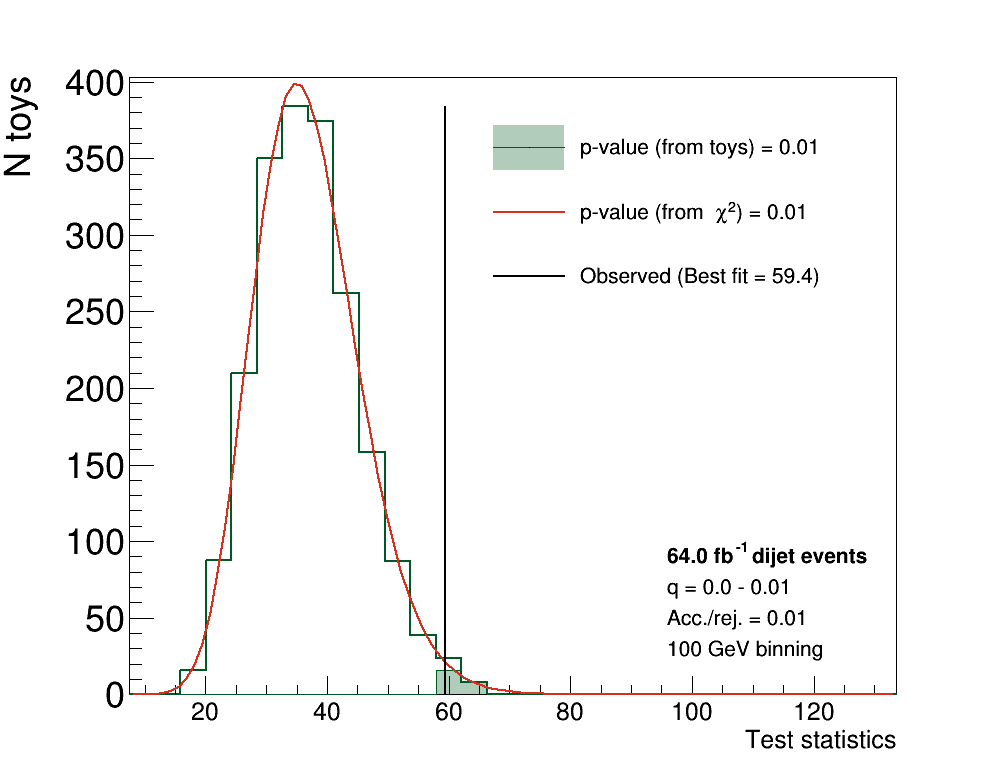

In [20]:
# Plot GOF
for i,qkey in enumerate(quants):
    if i>0:
        break
    if i > 0:
        lower_bound = quants[i-1]
    else:
       lower_bound = 0.0 
#     for sig_inj in sig_inj_vals:
    skey = int(0)
    quantile = int(qkey*100)
    prefix = 'inj{}fb_q{}percent'.format(skey,quantile)
    
    efficiency = qkey
    # open file
    obs_gof_file = uproot.open('higgsCombine{WNAME}_Ratio_{P}.GoodnessOfFit.mH120.root'.format(P=prefix,WNAME=wsfile))
    obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

    exp_gof_file = uproot.open('higgsCombine{WNAME}_Ratio_{P}.GoodnessOfFit.mH120.123456.root'.format(P=prefix,WNAME=wsfile))
    exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
    
    # get p-value from toys
    n_extreme = len(exp_gof[exp_gof > obs_gof])
    n_total = len(exp_gof)
    pval_toys = 1.*n_extreme/n_total
    
    # get p-value assuming chi2 dist (may not be valid)
    pval = rt.TMath.Prob(obs_gof,n_bins)
    print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))
    
    bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
    exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
    exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
    for g in exp_gof: 
        exp_gof_hist.Fill(g)
        if g > obs_gof: 
            exp_gof_hist_gt.Fill(g)
        
        
    d = rt.TCanvas("ratio", "", 1000, 800)
    d.SetLeftMargin(0.13)
    # signal_hist_template    .Draw('same HIST')
    
    rt.gStyle.SetOptTitle(0)
    rt.gStyle.SetOptStat(0)
    f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))

    tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
    tleg.SetTextSize(0.05)
    tleg.SetBorderSize(0)
    tleg.SetFillStyle(0)
    tleg.SetTextSize (0.03)
    tleg.SetTextFont( 62 )
    tleg.SetTextSize (0.03)
    tleg.SetTextFont( 42 )
    exp_gof_hist.Draw('hist')
    exp_gof_hist.SetXTitle('Test statistics')
    exp_gof_hist.SetYTitle('N toys')
    exp_gof_hist.SetTitle("")
    exp_gof_hist.GetYaxis().SetLabelSize(0.05)
    exp_gof_hist.GetYaxis().SetTitleSize(0.05)
    f.SetLineColor((rt.TColor.GetColor(scol[1])))
    exp_gof_hist.SetLineWidth(2)
    exp_gof_hist.SetLineColor((rt.TColor.GetColor(bcol[0])))
    exp_gof_hist_gt.SetLineColor((rt.TColor.GetColor(bcol[0])))
    exp_gof_hist_gt.SetFillColorAlpha((rt.TColor.GetColor(bcol[0])), 0.30)
    exp_gof_hist_gt.Draw('fhistsame')
    f.Draw('same')
    line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
    line.SetLineWidth(2)
    line.Draw()
    tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
    tleg.AddEntry(f,'p-value (from #chi^{2}) = %.2f'%pval,'l')
    tleg.AddEntry(line,'Observed (Best fit = {:.1f})'.format(obs_gof),'l')
    tleg.Draw()
    latex = rt.TLatex()
    latex.SetNDC ()
    latex.SetTextSize (0.03)
    latex.SetTextFont( 62 )
    latex.DrawLatex (0.67 ,0.27 , "%.1f fb^{-1} dijet events"%lumi)
    latex.SetTextSize (0.03)
    latex.SetTextFont( 42 )
    latex.DrawLatex(0.67 ,0.23 , 'q = {} - {}'.format(lower_bound,qkey))
    latex.DrawLatex(0.67 ,0.19 , "Acc./rej. = {:.2f}".format(efficiency))
    latex.DrawLatex(0.67 ,0.15 , "100 GeV binning")
    d.Draw()
    d.SaveAs('gof_{}_100GeVbinning.pdf'.format(prefix))



In [ ]:
# # set up workspace, combined
# acc_bin_functions_all = {}
# rej_bin_functions_all = {}
# for i,key in enumerate(sorted(histos_data.keys())):
#     prefix = 'q'+str(int(key*100))
#     print('Working on quantile {}'.format(prefix))
    
#     datacard_ws = rt.TFile.Open('datacard_ws_{}.root'.format(prefix),'recreate')
#     w = rt.RooWorkspace('w','w')
#     # Set up mjj in dijet invariant mass range and import
#     x = rt.RooRealVar('x','x',min_bin,max_bin)
#     w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

#     # Set up the correct efficiency which should yield data_observed = efficiency*background_template
#     w.factory('eff_%s[%f,0,1]'%(prefix,histos_data[key].Integral()/background_hist_template.Integral()))
#     w.var('eff_{}'.format(prefix)).setConstant(True)
#     print('eff_{}'.format(prefix))
#     print(histos_data[key].Integral()/background_hist_template.Integral())
#     #Loop over all bins and set 
#     # - background template per bin as crBin_func = (mjj_in+mjj_in/sqrt(mjj_in))^crBin
#     # - accepted template based on quantile used as bin = eff * crBin+func
#     acc_bin_functions = rt.RooArgList()
#     rej_bin_functions = rt.RooArgList()
#     empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
#     for iBinX in range(1,n_bins+1):
#         empty_hist.SetBinContent(iBinX,1)
#         w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_template.GetBinContent(iBinX)))
#         w.factory('crBin%i[0,-100,100]'%(iBinX))
#         w.var('crBin%i_In'%iBinX).setConstant(True)
#         w.var('crBin%i'%iBinX).setConstant(False)
#         if background_hist_template.GetBinContent(iBinX) == 0:
#             w.factory("expr::crBin%iFunc('max(0,@0)',crBin%i_In)"%(iBinX,iBinX))
#         else:    
#             w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_hist_template.GetBinContent(iBinX)),iBinX,iBinX))
#         w.factory("expr::bin%iFunc_%s('max(0,@0*@1)',eff_%s,crBin%iFunc)"%(iBinX,prefix,prefix,iBinX))
#         rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
#         acc_bin_functions.add(w.function('bin%iFunc_%s'%(iBinX,prefix)))
#     acc_bin_functions_all[key] = acc_bin_functions
#     rej_bin_functions_all[key] = rej_bin_functions
    
#     #Create the parametric histograms from the functions defined above
#     qcd_rph_rej = rt.RooParametricHist('background_rej','background_rej',w.var('x'),rej_bin_functions,empty_hist)
#     qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
#     qcd_rph_acc = rt.RooParametricHist('background_acc_{}'.format(prefix),'background_acc_{}'.format(prefix),w.var('x'),acc_bin_functions,empty_hist)
#     qcd_rph_acc_norm = rt.RooAddition('background_acc_norm_{}'.format(prefix),'background_acc_norm_{}'.format(prefix),acc_bin_functions)

#     #Import all
#     getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
#     getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
#     getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
#     getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())
    
#     ds_signal_acc = rt.RooDataHist('signal_acc_{}'.format(prefix),'signal_acc_{}'.format(prefix),rt.RooArgList(w.var('x')),histos_signal[key])
#     ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_template)
#     getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
#     getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())
    
#     # Import data, no injected signal (baseline) and with injected signal
#     ds_data_acc = {}
#     ds_data_rej = {}
#     data_acc = rt.RooDataHist('data_obs_acc_%s'%(prefix),'data_obs_acc_%s'%(prefix),rt.RooArgList(w.var('x')),histos_data[key])
#     data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),background_hist_template)

#     getattr(w,'import')(data_acc, rt.RooCmdArg())
#     getattr(w,'import')(data_rej, rt.RooCmdArg())
        
#     for sig_inj in sig_inj_vals:
#         print (sig_inj)
#         print (data_hist_acc_inj_all[key][sig_inj].GetName())
#         print (data_hist_acc_inj_all[key][sig_inj].Integral())

#         ds_data_acc[sig_inj] = rt.RooDataHist('data_obs_inj%i_acc_%s'%(sig_inj,prefix),'data_obs_inj%i_acc_%s'%(sig_inj,prefix),rt.RooArgList(w.var('x')),data_hist_acc_inj_all[key][sig_inj])
#         ds_data_rej[sig_inj] = rt.RooDataHist('data_obs_inj%i_rej'%(sig_inj),'data_obs_inj%i_rej'%sig_inj,rt.RooArgList(w.var('x')),data_hist_rej_inj_all[key][sig_inj])

#         getattr(w,'import')(ds_data_acc[sig_inj], rt.RooCmdArg())
#         getattr(w,'import')(ds_data_rej[sig_inj], rt.RooCmdArg())
    
#     datacard_ws.cd()
#     w.Write()
#     datacard_ws.Close()

In [ ]:
# # set up workspace
# # Assume there is signal present both in rejected and accepted  (before: just background shape with no signal)
# for sig_inj in sig_inj_vals:
#     print (sig_inj)
#     for i,key in enumerate(sorted(histos_data.keys())):
#         if key == 1:
#             continue
        
#         prefix = 'q'+str(int(key*100))
#         print('Working on quantile {}'.format(prefix))
        
#         background_template = data_hist_rej_inj_all[key][sig_inj]
#         data                = data_hist_acc_inj_all[key][sig_inj]
        
#         #Set up workspace
#         datacard_ws = rt.TFile.Open('datacard_ws_{}_inj{}.root'.format(prefix,sig_inj),'recreate')
#         w = rt.RooWorkspace('w','w')
#         # Set up mjj in dijet invariant mass range and import
#         x = rt.RooRealVar('x','x',min_bin,max_bin)
#         w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))
        
#         #Importing data with injected signal = {sig_inj}
#         print ('Using data set = {}'.format(data.GetName()))
#         print ('Yield = {}'.format(data.Integral()))
        
        
#         ds_signal_acc = rt.RooDataHist('signal_acc_{}'.format(prefix),'signal_acc_{}'.format(prefix),rt.RooArgList(w.var('x')),histos_signal[key])
#         ds_signal_rej = rt.RooDataHist('signal_rej_{}'.format(prefix),'signal_rej_{}'.format(prefix),rt.RooArgList(w.var('x')),signal_hist_template)
#         getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
#         getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

#         # Import data
#         ds_data_acc = {}
#         ds_data_rej = {}
#         data_acc = rt.RooDataHist('data_obs_acc_%s'%(prefix),'data_obs_acc_%s'%(prefix),rt.RooArgList(w.var('x')),data)
#         data_rej = rt.RooDataHist('data_obs_rej_%s'%(prefix),'data_obs_rej',rt.RooArgList(w.var('x')),background_template)
#         getattr(w,'import')(data_acc, rt.RooCmdArg())
#         getattr(w,'import')(data_rej, rt.RooCmdArg())
        
            
#         # Set up the correct efficiency which should yield data_observed = efficiency*background_template
        
#         print('Setting efficiency as : eff_{}'.format(prefix))
#         print('Setting efficiency value : eff_{}'.format(data.Integral()/background_template.Integral()))

#         w.factory('eff_%s[%f,0,1]'%(prefix,data.Integral()/background_template.Integral()))
#         w.var('eff_{}'.format(prefix)).setConstant(True)
    

#         #Loop over all bins and set 
#         # - background template per bin as crBin_func = (mjj_in+mjj_in/sqrt(mjj_in))^crBin
#         # - accepted template based on quantile used as bin = eff * crBin+func
#         acc_bin_functions = rt.RooArgList()
#         rej_bin_functions = rt.RooArgList()
#         empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
#         for iBinX in range(1,n_bins+1):
#             empty_hist.SetBinContent(iBinX,1)
#             w.factory('crBin%i_In[%.1f]'%(iBinX,background_template.GetBinContent(iBinX)))
#             w.factory('crBin%i[0,-100,100]'%(iBinX))
#             w.var('crBin%i_In'%iBinX).setConstant(True)
#             w.var('crBin%i'%iBinX).setConstant(False)
#             if background_hist_template.GetBinContent(iBinX) == 0:
#                 print('Bin content is zero! Setting crBin{}Func to zero in fit.'.format(iBinX))
#                 w.factory("expr::crBin%iFunc(0)")
#             else:    
#                 w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_template.GetBinContent(iBinX)),iBinX,iBinX))
#             w.factory("expr::bin%iFunc_%s('max(0,@0*@1)',eff_%s,crBin%iFunc)"%(iBinX,prefix,prefix,iBinX))
#             rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
#             acc_bin_functions.add(w.function('bin%iFunc_%s'%(iBinX,prefix)))
#         acc_bin_functions_all[key] = acc_bin_functions
#         rej_bin_functions_all[key] = rej_bin_functions

#         #Create the parametric histograms from the functions defined above
#         qcd_rph_rej = rt.RooParametricHist('background_rej_{}'.format(prefix),'background_rej',w.var('x'),rej_bin_functions,empty_hist)
#         qcd_rph_rej_norm = rt.RooAddition('background_rej_norm_{}'.format(prefix),'background_rej_norm',rej_bin_functions)
#         qcd_rph_acc = rt.RooParametricHist('background_acc_{}'.format(prefix),'background_acc_{}'.format(prefix),w.var('x'),acc_bin_functions,empty_hist)
#         qcd_rph_acc_norm = rt.RooAddition('background_acc_norm_{}'.format(prefix),'background_acc_norm_{}'.format(prefix),acc_bin_functions)

#         #Import all
#         getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
#         getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
#         getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
#         getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

#         datacard_ws.cd()
#         w.Write()
#         datacard_ws.Close()

In [ ]:
# # datacard template
# # no background normalization uncertainty
# combine_strings = {}
# for sig_inj in sig_inj_vals:
#     print (sig_inj)
    
#     combine_string = u'combineCards.py '.format(sig_inj)
#     for i,key in enumerate(sorted(histos_data.keys())):
#         if key == 1.0:
#             continue
#         prefix = 'q'+str(int(key*100))

#         datacard_ratio = \
#         '''
#         imax 1
#         jmax 1
#         kmax *
#         ---------------
#         shapes * * {WORKSPACE} w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
#         ---------------
#         bin {BIN}
#         observation {OBS}
#         ------------------------------
#         bin             {BIN}      {BIN}
#         process         signal     background
#         process         0          1
#         rate            {SIGRATE}    {BKGRATE}
#         --------------------------------
#         lumi lnN 1.01 -
#         eff_{PREFIX}   flatParam
#         '''

#         for i in range(1,n_bins+1):
#             datacard_ratio += 'crBin%i   flatParam\n'%i

#         datacard_ws = 'datacard_ws_{}_inj{}.root'.format(prefix,sig_inj)

#         # write datacard
#         datacard_ratio_acc = datacard_ratio.format(BIN='acc_{}'.format(prefix),
#                                   OBS=-1,
#                                   BKGRATE=1,
#                                   SIGRATE=histos_signal[key].Integral(),
#                                   WORKSPACE=datacard_ws,
#                                   PREFIX=prefix)
#         print(datacard_ratio_acc)
#         with open('datacard_ratio_acc_{}_inj{}.txt'.format(prefix,sig_inj),'w') as f:
#             f.write(datacard_ratio_acc)
#         combine_string += 'acc_{}=datacard_ratio_acc_{}_inj{}.txt '.format(prefix,prefix,sig_inj)

#         datacard_ratio_rej = datacard_ratio.format(BIN='rej_{}'.format(prefix),
#                                                OBS=-1,
#                                                BKGRATE=1,
#                                                SIGRATE=signal_hist_template.Integral(),
#                                                WORKSPACE=datacard_ws,
#                                                PREFIX=prefix) 
#         print(datacard_ratio_rej)
#         with open('datacard_ratio_rej_{}_inj{}.txt'.format(prefix,sig_inj),'w') as f:
#                 f.write(datacard_ratio_rej)
#         combine_string += 'rej_{}=datacard_ratio_rej_{}_inj{}.txt '.format(prefix,prefix,sig_inj)
        
#     combine_string += ' > datacard_ratio_inj{}.txt'.format(sig_inj)  
#     combine_strings[sig_inj] = combine_string
    
# for key in combine_strings.keys():
#     print (combine_strings[key])
#     print('\n')

In [ ]:
# for key in combine_strings.keys():
#     print (combine_strings[key])
#     print('\n')
#     get_ipython().system(combine_strings[key])
#     get_ipython().system(u'text2workspace.py datacard_ratio_inj{}.txt'.format(key))

In [ ]:
# get_ipython().system(u'combineCards.py rej=datacard_ratio_rej_inj0.0.txt acc_q1=datacard_ratio_acc_q1_inj0.0.txt > datacard_test_inj0_q1.txt')
# get_ipython().system(u'text2workspace.py datacard_test_inj0_q1.txt')

In [ ]:
# get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_test.root -n Ratio_inj0 --dataset data_obs_inj0 -v 2')

In [ ]:
# sig_inj_vals = [0.,0.1,1.,2.,5.,10.]
# for sig_inj in sig_inj_vals:
#     # get obseverved goodness of fit test statistic (signal strength = 0)
#     get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -n Ratio_inj%i --dataset data_obs_inj%i'%(sig_inj,sig_inj))

#     processes = []
#     # get expected goodness of fit test statistic distribution from frequentist toys
#     for i in range(10):
#         command = 'combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 200 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i)
#         processes.append(Popen(shlex.split(command)))
#         #get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i))
#     for p in processes:
#         p.wait()
#     get_ipython().system('hadd -f higgsCombineRatio_inj%i.GoodnessOfFit.mH120.123456.root higgsCombineRatio_inj%i.GoodnessOfFit.mH120.4*.root'%(sig_inj,sig_inj))

In [ ]:
# obs_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.root')
# obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]